- 전처리 -> DataLoader
- DataLoader 가 중요함, 보통 에러가 여기서 남 
- 출력층만 넣어서 바로 결과물을 뽑아낼수도 있음 (chat gpt 방식 : 질문을 넣으면 어떠한 답변형태로 나올 수 있게)  
- 사전에 가진 모든 구조를 가지고 우리의 요구사항을 더해서 ai 서비스를 만듦 

# 전이 학습(transfer learning)

<img src = './image/transfer_learning.png'>

- 일반적으로 합성곱 신경망 기반으로 딥러닝 모델을 제대로 훈련시키려면 많은 양의 데이터가 필요함 
- 하지만 큰 데이터셋을 확보하고 훈련시키는 데에 많은 돈과 시간이 필요 
- 이러한 문제를 해결하기 위해 전이 학습을 이용 
- 전이 학습(transfer learning)
    - 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용하는 것 
        - 이때 아주 큰 데이터셋을 사용하여 훈련된 모델을 사전 학습 모델(사전 훈련된 모델)이라고 함 
    - 전이 학습을 이용하면 비교적 적은 수의 데이터를 가지고도 원하는 과제를 해결할 수 있음 

## 특성 추출 기법(feature extractor)

<img src = './image/feature_extractor.jpg'>

- 사전 학습 모델을 가져온 후 완전연결층 부분만 새로 만듦
- 학습할 때는 완전연결층만 학습하고 나머지 계층은 학습되지 않도록 함
    - 데이터 분류기(완전연결층) : 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분
    
- 자주 사용되는 이미지 분류 사전학습 모델
    - Xeption
    - Inception V3
    - ResNet50
    - VGG16
    - BGG19
    - MobileNet

In [1]:
# 데이터복제를 의도치 않게 많이하면 터질때 이걸 쓰면 됨 
# 파이토치와 matplotlib 의 충돌 
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [11]:
import os
import time
import copy
import glob
import shutil
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = './data/catanddog/train'

# Compose : 기본 전처리 
transform = transforms.Compose([
    transforms.Resize([256, 256]), # Resize : 가로세로 크기 정함
    transforms.RandomResizedCrop(224), # RandomResized: 이미지 데이터를 랜덤하게 사이즈 조절 
    transforms.RandomHorizontalFlip(), # 뒤집어주고 
    transforms.ToTensor(),
])

In [4]:
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform = transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 32,
    num_workers = 8,
    shuffle = True)

In [5]:
print(len(train_dataset))

385


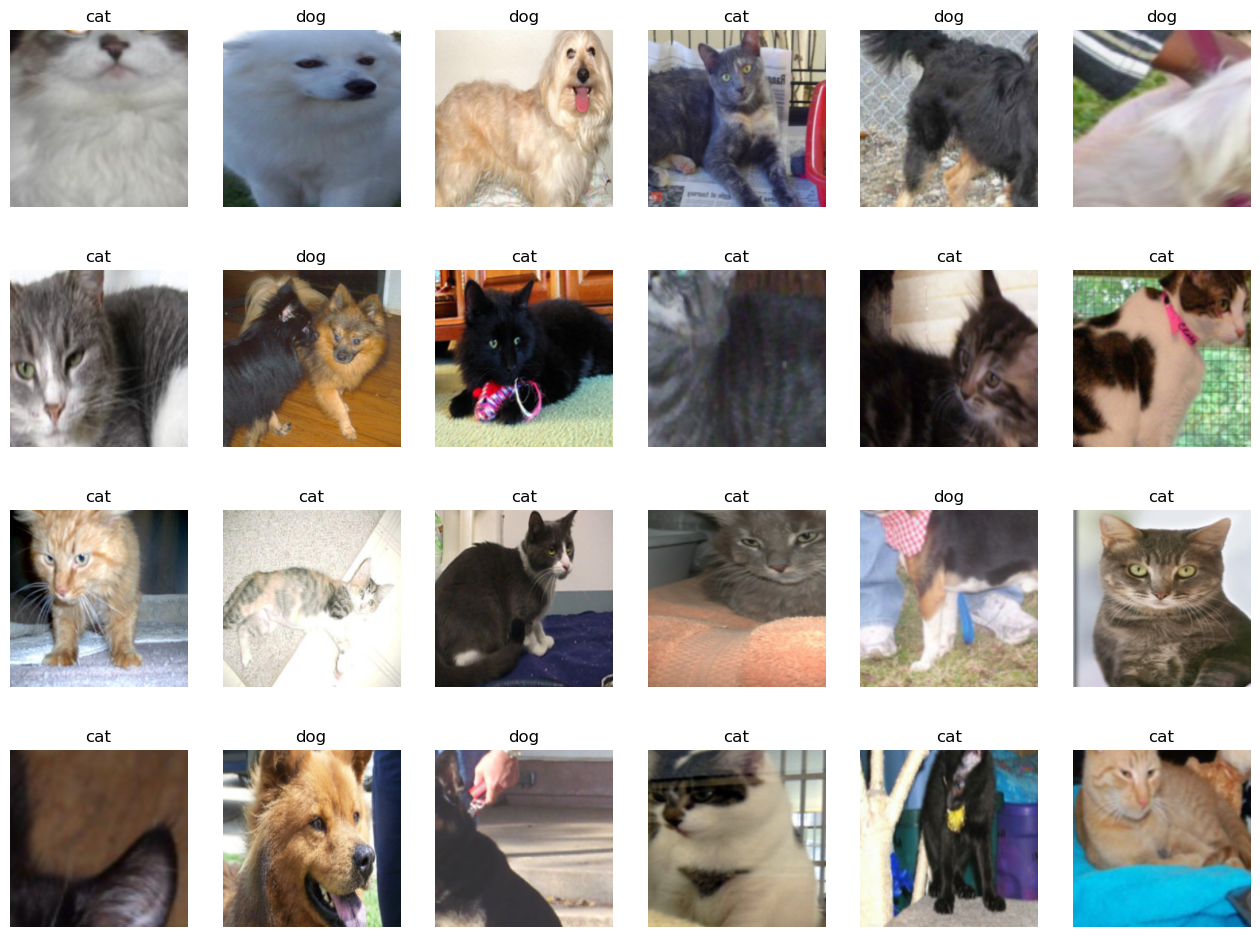

In [6]:
# 학습에 사용될 이미지 출력
samples, labels = next(iter(train_loader)) # train_loader에서 데이터를 하나씩 꺼내오기 
classes = {0 : 'cat', 1: 'dog'}

fig = plt.figure(figsize= (16, 24))

for i in range(24):
    a = fig.add_subplot(4, 6, i + 1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0))) 
    # 3, 224, 224, 크기를 224, 224, 3 으로 변환  
    
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)

- 케라스 : 한칸을 구성하는 요소 ( 빨파초) 3개 
- 파이토치 : 3개가 합쳐서 한칸 1 개 

In [7]:
samples.shape

torch.Size([32, 3, 224, 224])

In [8]:
# transpose에서 축을 옮김 
np.transpose(samples[0].numpy(), (1, 2, 0)).shape

(224, 224, 3)

# 사전학습 모델 준비

In [10]:
# weights = 'IMAGENET1K_V1' :  IMAGENET1K_V1 데이터로 사전 학습된 가중치를 사용하겠다
resnet18 = models.resnet18(weights = 'IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ITSC/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:02<00:00, 22.9MB/s]


##  ResNet18

- 50개의 계층으로 구성된 합성곱 신경망
- ImageNet 데이터베이스의 100만개가 넘는 영상을 이용하여 훈련된 신경망
- 입력 제약이 매우 크고 충분한 메모리(RAM)가 없으면 학습 속도가 느려지는 단점이 있음 

In [13]:
def set_parameter_requires_grad(model, feature_extracting = True):
    '''
    ResNet18 이 파라미터 학습을 하지 않도록 고정 
    '''
    if feature_extracting:
        for param in model.parameters(): 
        # 케라스의 아담 같은 녀석 # 모델전체의 파라미터 # 가중치 
            param.requires_grad = False
            # 역전파 중 파라미터들에 대한 변화를 계산할 필요 없음 

In [14]:
set_parameter_requires_grad(resnet18)

## 완전 연결층 추가

In [16]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- resnet 이미지 가중치가 되어 있지만 
- 맨 마지막 층 (fc) : in_features=512, 1000개를 출력함 

- (fc): Linear(in_features=512, out_features=2, bias=True) 
- 맨 아랫층만 학습할것임 

In [29]:
def train_model(model, dataloaders, criterion, optimzer, device, num_epochs = 13, is_train = True):
    '''
    파라미터 : (모델, 학습데이터, 손실함수criterion, 옵티마이저 )
    '''
    since = time.time()
    acc_history = []
    loss_history = []
    bets_acc = 0.0 
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        running_loss = 0.0
        running_corrects = 0
        
        # 한 배치 안에서의 로스 
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimzer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward() # 그레디언트 계산
            optimzer.step() #가중치 조절 
            
            running_loss += loss.item() * inputs.size(0) 
            # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장 
            running_corrects += torch.sum(preds == labels.data)
            
        # for문이 다 돌고나서 epoch가 도는것임 
        # 1 에포크가 돌고나서 해당 로스 계산 
        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc= running_corrects.double() / len(dataloaders.dataset)
        
        print(f'Loss: {epoch_loss:.4f} ACC: {epoch_acc:.4f}')
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            
        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('./data/catanddog/', f'{epoch:0.2}.pth'))
        print()
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Acc: {best_acc:.4f}')
    return acc_history, loss_history

In [15]:
resnet18.fc = nn.Linear(512, 2) # 출력층 바꿔줌 
# 클래스가 2개 : 개랑 고양이 니까 2개의 범주로 뽑아 낼수 있게 함 

In [17]:
# 모델 파라미터 값 확인
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        # requires_grad = False: 학습 안하는 것임 
        # if문에 쓰이면 True에만 쓰이고, True는 학습을 하는 파라미터 
        
        print(name, param.data)

fc.weight tensor([[-0.0247, -0.0336,  0.0334,  ...,  0.0077,  0.0249, -0.0214],
        [ 0.0290,  0.0379,  0.0392,  ..., -0.0064, -0.0369, -0.0388]])
fc.bias tensor([-0.0110,  0.0276])


# 모델 학습 

In [34]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs = 13, is_train = True):
    '''
    파라미터 : (모델, 학습데이터, 손실함수, 옵티마이저, 장치)
    '''
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch} / {num_epochs - 1}")
        print("-" * 10)
        
        running_loss = 0.0
        running_corrects = 0
        
        # 한 배치 안에서의 로스 
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward() # 그레디언트 계산
            optimizer.step() #가중치 조절 
            
            running_loss += loss.item() * inputs.size(0)
            # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data)
            
         # for문이 다 돌고나서 epoch가 도는것임 
        # 1 에포크가 돌고나서 해당 로스 계산     
        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        
        print(f"Loss : {epoch_loss:.4f} ACC : {epoch_acc:.4f}")
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            
        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join("./data/catanddog/", f"{epoch}.pth"))
        print()
        
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Acc: {best_acc:.4f}")
    return acc_history, loss_history

In [35]:
params_to_update = []

# 어떤 파라미터들이 옵티마이저로 전달되는지 설정 
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(name)

fc.weight
fc.bias


In [36]:
optimizer = optim.Adam(params_to_update)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

In [38]:
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer,
                                              device)

Epoch 0 / 12
----------
Loss : 0.2445 ACC : 0.9221

Epoch 1 / 12
----------
Loss : 0.2748 ACC : 0.8675

Epoch 2 / 12
----------
Loss : 0.2525 ACC : 0.9065

Epoch 3 / 12
----------
Loss : 0.1932 ACC : 0.9299

Epoch 4 / 12
----------
Loss : 0.2288 ACC : 0.9013

Epoch 5 / 12
----------
Loss : 0.2111 ACC : 0.9195

Epoch 6 / 12
----------
Loss : 0.2733 ACC : 0.8623

Epoch 7 / 12
----------
Loss : 0.2375 ACC : 0.8935

Epoch 8 / 12
----------
Loss : 0.1893 ACC : 0.9091

Epoch 9 / 12
----------
Loss : 0.1685 ACC : 0.9377

Epoch 10 / 12
----------
Loss : 0.2209 ACC : 0.9039

Epoch 11 / 12
----------
Loss : 0.2063 ACC : 0.9065

Epoch 12 / 12
----------
Loss : 0.1682 ACC : 0.9325

Training complete in 3m 6s
Best Acc: 0.9377


# 테스트 데이터 평가

In [39]:
test_path = './data/catanddog/test'

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle = True
)

- 훈련이 아니라 테스트이기 때문에 사이즈조절만함, 랜덤 x 

In [40]:
# 총 98개의 데이터가 있음 
print(len(test_dataset))

98


In [41]:
# 평가
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0 
    
    saved_models = glob.glob('./data/catanddog/' + '*.pth')
    # 경로에서 pth 확장자를 갖는 파일을 가져오기
    saved_models.sort()
    print('saved_model', saved_models)
    
    # 1에포크 훈련하고 저장하고 2에포크돌리고 저장
    # 에포크마다 저장을 했음 
    # 그모델들을 하나하나 읽어서 어떤 모델이 베스트인지 테스트
    for model_path in saved_models:
        print('Loading model', model_path)
        
        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0
        
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.no_grad(): # 훈련을 하지 않으므로 (gradient)자동 미분 계산 필요 없음 
                outputs = model(inputs) # 결과물이 나옴
                
            # 그 결과물로 예측값 뽑아내기
            _, preds = torch.max(outputs.data, 1) # 주어진 텐서 배열의 최댓값의 index를 반환
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0 # 0.5가 안되면 0으로 변환
            running_corrects += preds.cpu().eq(labels.cpu()).int().sum() # int로변환후 sum # 맞힌 것의 갯수
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print(f'Acc: {epoch_acc:.4f}')
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            
        acc_history.append(epoch_acc.item())
        print()
        
    time_elapsed = time.time() - since
    print(f'Validation complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Acc: {best_acc:.4f}')
    
    return acc_history

- best 정확도를 저장, 그거와 관계없이 정확도 히스토리를 남길 것임
- 시간 얼마나 걸렸는지 체크 

In [42]:
# 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['./data/catanddog\\0.pth', './data/catanddog\\1.pth', './data/catanddog\\10.pth', './data/catanddog\\11.pth', './data/catanddog\\12.pth', './data/catanddog\\2.pth', './data/catanddog\\3.pth', './data/catanddog\\4.pth', './data/catanddog\\5.pth', './data/catanddog\\6.pth', './data/catanddog\\7.pth', './data/catanddog\\8.pth', './data/catanddog\\9.pth']
Loading model ./data/catanddog\0.pth
Acc: 0.9592

Loading model ./data/catanddog\1.pth
Acc: 0.9388

Loading model ./data/catanddog\10.pth
Acc: 0.9490

Loading model ./data/catanddog\11.pth
Acc: 0.9490

Loading model ./data/catanddog\12.pth
Acc: 0.9490

Loading model ./data/catanddog\2.pth
Acc: 0.9490

Loading model ./data/catanddog\3.pth
Acc: 0.9388

Loading model ./data/catanddog\4.pth
Acc: 0.9490

Loading model ./data/catanddog\5.pth
Acc: 0.9286

Loading model ./data/catanddog\6.pth
Acc: 0.9388

Loading model ./data/catanddog\7.pth
Acc: 0.9286

Loading model ./data/catanddog\8.pth
Acc: 0.9490

Loading model ./data/catanddog

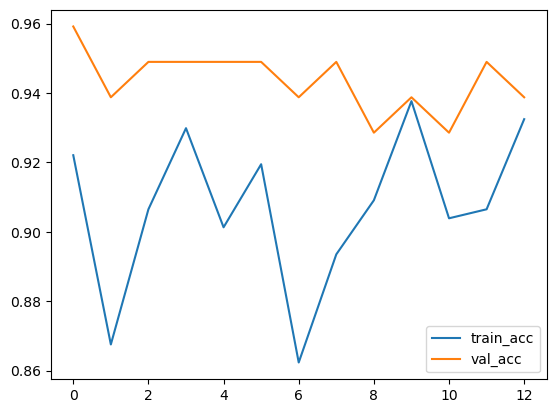

In [43]:
# 시각화
plt.plot(train_acc_hist, label = 'train_acc')
plt.plot(val_acc_hist, label = 'val_acc')
plt.legend()
plt.show()

# 예측 이미지 출력

In [44]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    # 기존 텐서의 내용을 복사한 텐서를 생성 
    image = image.transpose(1, 2, 0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1)
    return image

- 텐서 복사 명령어 비교
    - tensor.clone()
        - 메모리 : 새롭게 할당
        - 계산 그래프에 계속 상주(기울기에 영향을 줌)
        
    - tensor.detach()
        -  메모리 : 공유해서 사용
        - 계산 그래프에 계속 상주하지 않음(기울기에 영향을 안줌)
        
    - tensor.clone().detach()
        - 메모리 : 새롭게 할당
        - 계산 그래프에 상주하지 않음 

In [45]:
classes = {0 : 'cat', 1 : 'dog'}

# 테스트 로더에서 데이터를 받아옴, 시각적으로 확인 가능하게 
dataiter = iter(test_loader) 
images, labels = next(dataiter)

# output : 예측치 
output = resnet18(images.to(device)) # 순전파를 통해서 예측값을 알아냄 
_, preds = torch.max(output, 1)

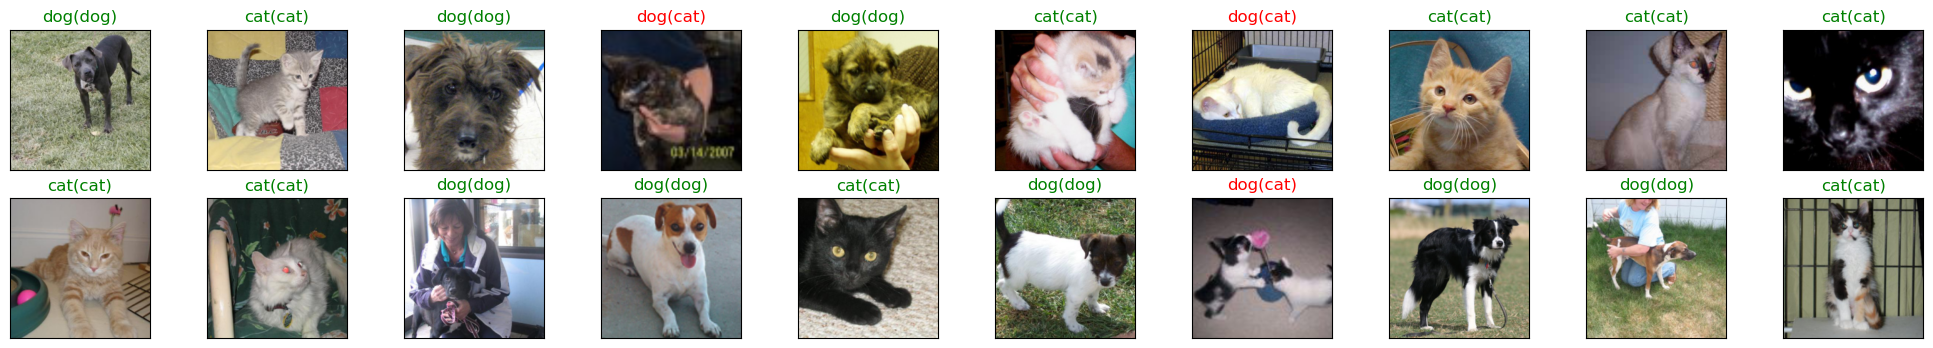

<Figure size 640x480 with 0 Axes>

In [47]:
fig = plt.figure(figsize = (25, 4))
for idx in np.arange(20): 
    ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = []) 
    # 행, 열, 인덱스, 축(삭제)
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title(f'{str(classes[preds[idx].item()])}({str(classes[labels[idx].item()])})',
                 color = ('green' if preds[idx] == labels[idx] else 'red'))
    
plt.show()
plt.subplots_adjust(bottom=0.2, top= 0.6, hspace= 0)

transformer
- 텍스트에서 시작이였으나 이미지, 영상에서 등등 쓰인다. 